# Tidy adjacent layer back-propagation code

The code in `001-adj-layer-backprop` was a mess and I'd like to clean it up for my sanity.

I'm wondering if NetworkX is really the approach I want to be using - it doesn't seem to parallelise anything (I suppose so it remains versatile for sparse graphs). Accessing attributes and filtering to subgraphs feels clunky. My graph is dense by definition so I wonder if I should just use pandas to store the nodes and edges and then load them into a NetworkX graph if I need to plot (not sure if I will need to plot...). Will do some research.

Pytorch geometric also feels like it could fit nicely with the fact I'm using tensors but maybe overkill because I'm not wanting to train stuff here (yet? 🤔).

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 2375343802  # this one is very interesting
set_all_seeds(seed)
print(seed)

2375343802


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


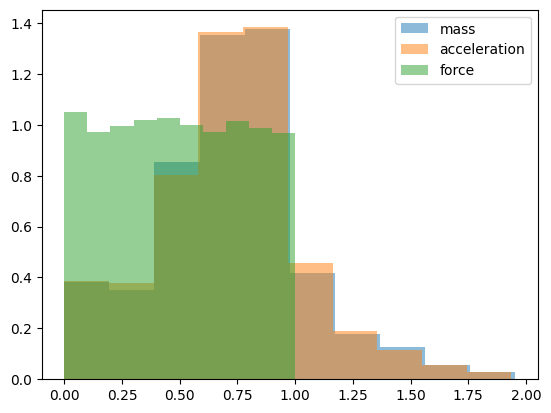

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

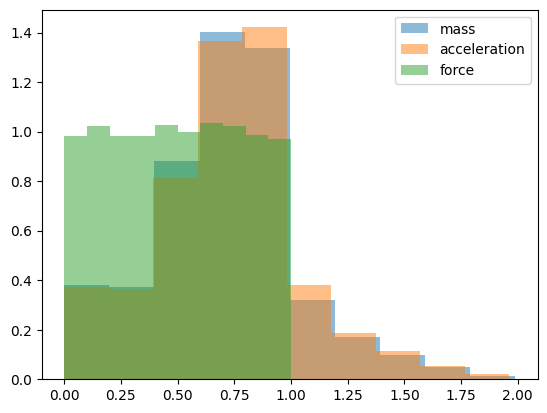

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

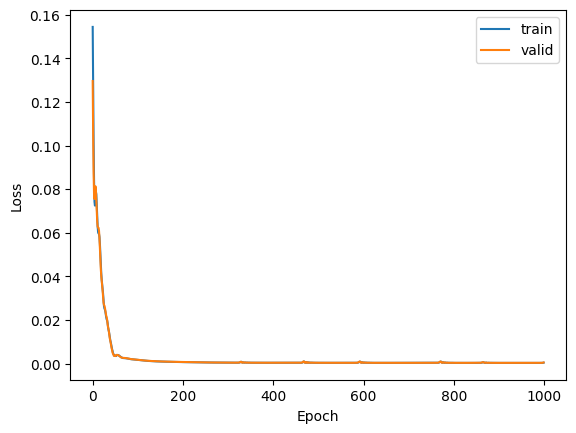

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0005)

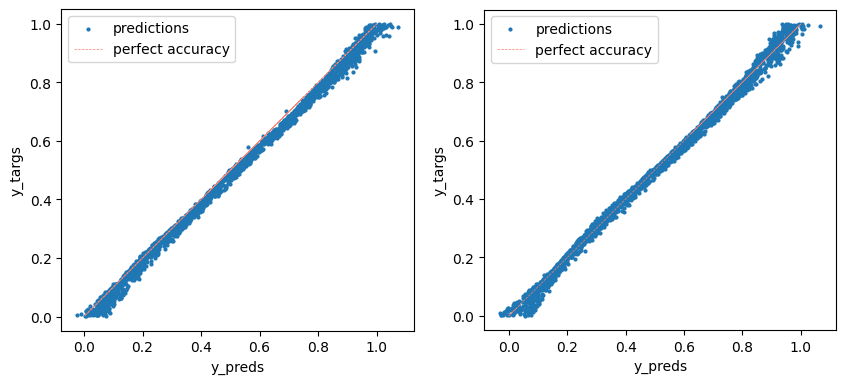

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [18]:
from physics_mi.analysis import capture_intermediate_outputs

In [19]:
def get_task_inputs(N=100, vary_task="A"):
    """
    Generates a dataset with N^2 examples for one of the two tasks (A or B). In each task subset, the other task's
    inputs are held constant and the alternative's task's inputs are varied across all the
    possible values in the interval [0,1] with precision 1/N.

    The purpose is to allow us to study how different tasks are represented in the dataset.

    Args:
        N (int, optional): Number of steps to sample unit input square. Defaults to 100.
        vary_task (str, optional): Which task to vary (the other's inputs will remained fixed at [0.5,0.5]). Defaults to "A".

    Returns:
        data: (N^2,4) the task dataset
    """
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [20]:
task_inputs = torch.cat(
    (get_task_inputs(100, vary_task="A"), get_task_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [21]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios["input"] = task_inputs

In [22]:
valid_ios["layers.0.act"].shape, valid_ios["layers.1.act"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [23]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [24]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [25]:
# required because torch.unique does not preserve order of appearance and doesn't provide indices (https://github.com/pytorch/pytorch/issues/36748)
def unique(x, dim=0):
    unique, inverse, counts = torch.unique(
        x, dim=dim, sorted=True, return_inverse=True, return_counts=True
    )
    inv_sorted = inverse.argsort(stable=True)
    tot_counts = torch.cat((counts.new_zeros(1), counts.cumsum(dim=0)))[:-1]
    index = inv_sorted[tot_counts]
    return unique, inverse, counts, index

In [48]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

In [49]:
def get_output_layer_nodes(ios, output_lk):
    """
    We must treat the output layer differently because they are the backpropagation
    originators and they are in a privileged basis.
    """
    node_idx = 0  # we're always starting here (?)
    output = valid_ios[output_lk]
    num_classes = output.shape[1]
    indices = torch.arange(0, num_classes)
    one_hot = torch.eye(num_classes)[indices]
    nodes = []
    for cidx in range(output.shape[1]):
        node = {
            "node": node_idx,
            "layer": output_lk,
            "comp": one_hot[cidx],
            "norm": 1.0,
        }
        nodes.append(node)
        node_idx += 1
    return pd.DataFrame(nodes)

In [116]:
# def generate_graph(ios, layer_keys, scaffold_model):
#     # to get us started
#     gdf = get_output_layer_nodes(ios, layer_keys[-1])

#     node_idx = gdf["node"].max() + 1

#     nodes = []
#     edges = []

#     reversed_layer_keys = layer_keys[::-1]
#     reverse_indices = list(range(len(layer_keys) - 1))[::-1]

#     # iterate over pairs of layers at a time (moving backwards through the network)
#     for lidx, lk_input, lk_output in zip(
#         reverse_indices,
#         reversed_layer_keys[1:],
#         reversed_layer_keys[:-1],
#     ):
#         print(lidx, lk_input, lk_output)

#         # get output layer component activations
#         linputs = (
#             ios[lk_input].clone().requires_grad_(True)
#         )  # we're going to produce gradients in this
#         out = scaffold_model(lidx, linputs)
#         output_layer_subgraph = gdf.loc[gdf["layer"] == lk_output].reset_index(
#             drop=True
#         )
#         output_comps = torch.stack(
#             output_layer_subgraph["comp"].values.tolist()
#         ).float()
#         output_comp_norms = torch.as_tensor(
#             output_layer_subgraph["norm"].values
#         ).float()
#         output_comps = output_comps / output_comp_norms[:, None]
#         out = torch.einsum(
#             "ij,kj->ik", out, output_comps
#         )  # mapping onto the output components

#         # iterate through each node in output layer
#         for cidx, comp_act in enumerate(out.transpose(1, 0)):
#             loss = comp_act.mean()
#             loss.backward(retain_graph=True)
#             input_grads = linputs.grad.clone().detach()
#             uq_input_grads, _, _, index = unique(input_grads, dim=0)
#             uq_input_grads = uq_input_grads[
#                 torch.argsort(index)
#             ]  # now in order of appearance so they can be matched with grads from other output nodes (if needed)
#             uq_input_grad_norms = torch.norm(uq_input_grads, dim=1)

#             # save each unique gradient as a node
#             for grad, norm in zip(uq_input_grads, uq_input_grad_norms):
#                 norm = float(norm)
#                 node = {"node": node_idx, "layer": lk_input, "comp": grad, "norm": norm}
#                 edge = {
#                     "source": node_idx,
#                     "sink": output_layer_subgraph["node"].iloc[cidx],
#                     "weight": norm,
#                 }
#                 nodes.append(node)
#                 edges.append(edge)
#                 node_idx += 1
#             linputs.grad.zero_()
#         gdf = pd.concat((gdf, pd.DataFrame(nodes)))
#     edf = pd.DataFrame(edges)
#     gdf.set_index("node", inplace=True)

#     return gdf, edf


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


def generate_graph(ios, layer_keys, scaffold_model):
    """
    Generates a graph representation from intermediate activations and a scaffold model.

    Parameters:
    ios (dict): intermediate activation outputs
    layer_keys (list): Ordered list of layer keys.
    scaffold_model (ScaffoldModel): Trained model to process activations.

    Returns:
    tuple: DataFrames representing nodes and edges of the graph.
    """
    # Initial setup
    gdf = get_output_layer_nodes(ios, layer_keys[-1])
    node_idx = gdf["node"].max() + 1
    nodes = []
    edges = []

    # Iterate over pairs of layers (backwards)
    for layer_index, input_layer_key, output_layer_key in zip(
        reversed(range(len(layer_keys) - 1)),
        layer_keys[::-1][1:],
        layer_keys[::-1][:-1],
    ):
        print(layer_index, input_layer_key, output_layer_key)

        # Process output layer activations
        linputs, out = process_layer_activations(
            ios[input_layer_key], scaffold_model, layer_index
        )

        # Process each node in output layer
        for node_data in process_output_nodes(out, linputs, gdf, output_layer_key):
            nodes.append(node_data["node"])
            edges.append(node_data["edge"])
            node_idx += 1

    # Construct DataFrame
    gdf = pd.concat([gdf, pd.DataFrame(nodes)]).set_index("node")
    edf = pd.DataFrame(edges)

    return gdf, edf


def process_layer_activations(layer_input, model, layer_index):
    """
    Processes layer activations using the scaffold model.

    Parameters:
    layer_input (Tensor): Input for the layer.
    model (callable): Scaffold model.
    layer_index (int): Index of the layer.

    Returns:
    tuple: Processed inputs and outputs for the layer.
    """
    linputs = layer_input.clone().requires_grad_(True)
    out = model(layer_index, linputs)

    return linputs, out


def process_output_nodes(output_activations, linputs, graph_df, output_layer_key):
    """
    Processes output nodes to generate node and edge data.

    Parameters:
    output_activations (Tensor): Activations of the output layer.
    linputs (Tensor): Layer inputs with gradients.
    graph_df (DataFrame): DataFrame representing the graph nodes.
    output_layer_key (str): Key for the output layer.

    Returns:
    generator: Yields dictionaries containing node and edge data.
    """
    node_idx = graph_df["node"].max() + 1
    output_layer_subgraph = graph_df.loc[
        graph_df["layer"] == output_layer_key
    ].reset_index(drop=True)

    for cidx, comp_act in enumerate(output_activations.transpose(1, 0)):
        # Compute the mean and backpropagate to compute gradients
        loss = comp_act.mean()
        loss.backward(retain_graph=True)
        input_grads = linputs.grad.clone().detach()

        # Process unique gradients
        uq_input_grads, _, _, index = unique(input_grads, dim=0)
        uq_input_grads = uq_input_grads[torch.argsort(index)]
        uq_input_grad_norms = torch.norm(uq_input_grads, dim=1)

        # Create node and edge data
        for grad, norm in zip(uq_input_grads, uq_input_grad_norms):
            norm_val = float(norm)
            node_data = {
                "node": {
                    "node": node_idx,
                    "layer": output_layer_key,
                    "comp": grad,
                    "norm": norm_val,
                },
                "edge": {
                    "source": node_idx,
                    "sink": output_layer_subgraph["node"].iloc[cidx],
                    "weight": norm_val,
                },
            }
            yield node_data
            node_idx += 1

In [117]:
gdf, edf = generate_graph(ios, layer_keys, scaffold_model)

2 layers.1.act layers.2.linear.bias
1 layers.0.act layers.1.act


IndexError: single positional indexer is out-of-bounds

In [109]:
gdf

,layer,comp,norm
node,,,
0,layers.2.linear.bias,"[tensor(1.), tensor(0.)]",1.000000
1,layers.2.linear.bias,"[tensor(0.), tensor(1.)]",1.000000
2,layers.1.act,"[tensor(-8.5386e-05), tensor(0.0001), tensor(0...",0.000506
3,layers.1.act,"[tensor(-4.5303e-05), tensor(-6.6102e-05), ten...",0.000383
2,layers.1.act,"[tensor(-8.5386e-05), tensor(0.0001), tensor(0...",0.000506
...,...,...,...
679,input,"[tensor(-1.0918e-05), tensor(3.0507e-05), tens...",0.000383
680,input,"[tensor(3.1789e-05), tensor(0.0001), tensor(0....",0.000425
681,input,"[tensor(7.6391e-05), tensor(1.7252e-05), tenso...",0.000478


In [110]:
edf

,source,sink,weight
0,2,0,0.000506
1,3,1,0.000383
2,4,2,0.000758
3,5,2,0.000516
4,6,2,0.000628
...,...,...,...
677,679,23,0.000383
678,680,23,0.000425
679,681,23,0.000478
680,682,23,0.000285


In [68]:
import networkx as nx
from collections import defaultdict


G = nx.DiGraph()

node_idx = 0


grads = defaultdict(dict)

for lidx, lk_input, lk_output in zip(
    reverse_indices,
    reversed_layer_keys[1:],
    reversed_layer_keys[:-1],
):  # iterate over pairs of layers at a time
    print(lidx, lk_input, lk_output)
    linputs = valid_ios[lk_input].clone().requires_grad_(True)
    out = scaffold_model(lidx, linputs)
    output_layer_nodes = [
        node for node, attr in G.nodes(data=True) if attr.get("layer") == lk_output
    ]
    out_comps = torch.stack(
        [attrs["comp"] for _, attrs in G.subgraph(output_layer_nodes).nodes(data=True)]
    )
    out_comps = out_comps / torch.norm(
        out_comps, dim=1, keepdim=True
    )  # normalise because we want to examine the upstream weights, not downstream
    out = torch.einsum(
        "ij,kj->ik", out, out_comps
    )  # mapping onto the output components

    # through each node/component of the output layer
    for cidx, comp_act in enumerate(out.transpose(1, 0)):
        loss = comp_act.mean()
        loss.backward(retain_graph=True)
        input_grads = linputs.grad.clone().detach()
        grads[lk_input][cidx] = input_grads
        uq_input_grads, _, _, index = unique(input_grads, dim=0)
        uq_input_grads = uq_input_grads[
            torch.argsort(index)
        ]  # now in order of appearance so they can be matched with grads from other output nodes
        uq_input_grad_norms = torch.norm(uq_input_grads, dim=1)
        for grad, norm in zip(uq_input_grads, uq_input_grad_norms):
            norm = float(norm)
            node = (node_idx, {"layer": lk_input, "comp": grad, "norm": norm})
            G.add_node(node[0], **node[1])
            G.add_edge(node_idx, output_layer_nodes[cidx], weight=norm)
            node_idx += 1
        linputs.grad.zero_()

    print(f"N unique grads: {len(uq_input_grads)}")

NameError: name 'reverse_indices' is not defined

Now I need to create inter-component edges, i.e. how much do the gradients produced from one component affect another component. I _think_ I can do this by dotting the gradients with the other component's gradients and doing a sum aggregation or something but I need to be careful to make sure that the meaning of this weights is equivalent to the existing weights otherwise the graph will have inconsistencies.

I'm expecting to see:
- intra task connectivity - components for the same task share some inbound gradient directions
- very little inter task connectivity - components for different tasks do not share inbound gradient directions

**TODO:** modify the below to only do dot product between relevant gradients (i.e. the gradient in the same position for each output node e.g. 0th->0th, 1st->1st etc.)

In [22]:
# for lidx, (lk_input, lk_output) in enumerate(zip(layer_keys[:-1], layer_keys[1:])):
#     input_nodes = [
#         node for node, attr in G.nodes(data=True) if attr.get("layer") == lk_input
#     ]
#     output_nodes = [
#         node for node, attr in G.nodes(data=True) if attr.get("layer") == lk_output
#     ]
#     input_grads = [attr["comp"] for _, attr in G.subgraph(input_nodes).nodes(data=True)]
#     input_grads = torch.stack(input_grads)
#     input_nodes = torch.as_tensor(input_nodes)
#     for output_node in output_nodes:
#         relevant_nodes = torch.as_tensor(
#             [source for source, _, _ in G.in_edges(output_node, data=True)]
#         )  # we've already got weights for these
#         relevant_mask = torch.isin(input_nodes, relevant_nodes)
#         weights = torch.einsum(
#             "ij,kj->i", input_grads[~relevant_mask], input_grads[relevant_mask]
#         )
#         source_nodes = (input_nodes[~relevant_mask]).tolist()
#         target_nodes = [output_node] * len(source_nodes)
#         for source, target, weight in zip(source_nodes, target_nodes, weights):
#             G.add_edge(source, target, weight=float(weight))

In [23]:
for lidx, lk in enumerate(layer_keys):
    layer_nodes = [node for node, attr in G.nodes(data=True) if attr.get("layer") == lk]
    layer_nodes = sorted(layer_nodes)
    spacing = 1.0 / len(layer_nodes)
    Y = np.linspace(-0.5, +0.5, len(layer_nodes) + 2)[1:-1]
    for node, y in zip(layer_nodes, Y):
        G.nodes[node]["pos"] = (lidx, y)

In [24]:
max_width = 2.0

pos = nx.get_node_attributes(G, "pos")
edge_weights = nx.get_edge_attributes(G, "weight")
scaled_weights = {
    (u, v): weight / max(edge_weights.values()) * max_width
    for (u, v), weight in edge_weights.items()
}

In [25]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 10))

# # Draw nodes
# nx.draw_networkx_nodes(G, pos, node_color="gray", node_size=10)

# # Draw edges with weights influencing the line thickness
# for (u, v), weight in scaled_weights.items():
#     nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=weight, edge_color="gray")


# Draw node labels
# nx.draw_networkx_labels(G, pos, font_size=8)

# Optionally, draw edge labels (weights)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# plt.title("Graph with Weight-Based Edge Thickness")
# _ = plt.axis("off")  # Turn off the axis

Plotting the gradients in the inputs for each task input:

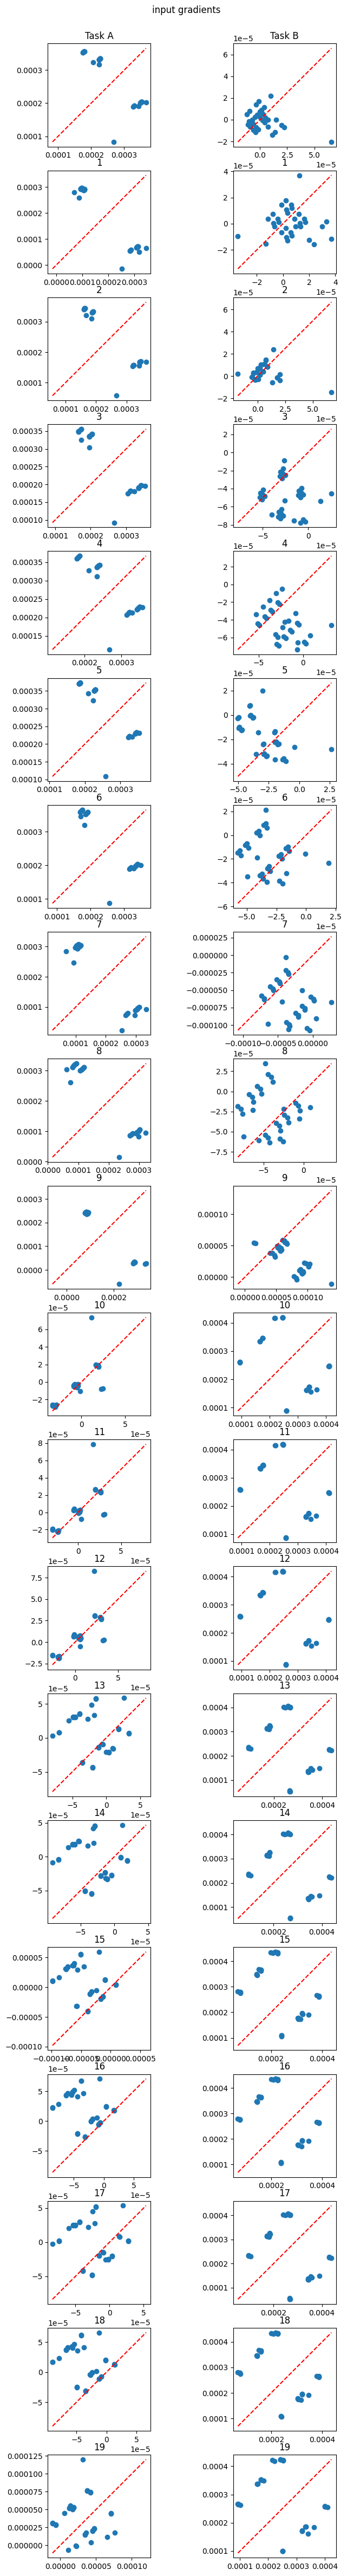

In [26]:
lk = layer_keys[0]

fig, axes = plt.subplots(len(grads[lk]), 2, figsize=(7, 50))

fig.tight_layout(rect=[0, 0.03, 1, 0.97])  # Adjust the position of the title

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        xy = grads[lk][i].unique(dim=0)
        if j == 0:
            xy = xy[:, :2].T
        if j == 1:
            xy = xy[:, 2:4].T

        ax.scatter(*xy)
        max_coord = xy.max()
        min_coord = xy.min()
        ax.plot([min_coord, max_coord], [min_coord, max_coord], color="red", ls="--")
        ax.set_aspect("equal")
        ax.set_title(i)

axes[0, 0].set_title("Task A")
axes[0, 1].set_title("Task B")

_ = fig.suptitle(f"{lk} gradients")  # Move the title after adjusting the layout

- We can see that they're symmetrical for the task relevant components. We'd expect that as the network should treat each intra-task input the same. 
- We can also see that they're roughly similar between each unique component. Haven't quite understood why this would be the case yet.

The fact that the gradients look similar to each other suggest that they might in fact be achieving the same thing. Then again, this could be a quirk of this particular task. Perhaps they are functioning similarly but slightly differently in order to achieve the appropriate scaling for $x_1x_2$.

## Node activations for each task

I'm going to see if I can visualise how the nodes activate for different tasks. This might explain potentially explain some things, we'll see.

In [27]:
sliceA = slice(0, 10000)
sliceB = slice(10000, None)

In [28]:
means = defaultdict(dict)
vars = defaultdict(dict)
for lk in layer_keys:
    neuron_acts = task_ios[lk]
    layer_nodes = [node for node, attr in G.nodes(data=True) if attr.get("layer") == lk]
    node_comps = torch.stack(
        [attr["comp"] for _, attr in G.subgraph(layer_nodes).nodes(data=True)]
    )
    node_acts = torch.einsum("ij,kj->ik", neuron_acts, node_comps)
    node_vars_A = node_acts[sliceA].var(dim=0)
    node_vars_B = node_acts[sliceB].var(dim=0)
    vars[lk]["A"] = node_vars_A
    vars[lk]["B"] = node_vars_B

    for i, node in enumerate(layer_nodes):
        G.nodes[node]["var_A"] = float(node_vars_A[i])
        G.nodes[node]["var_B"] = float(node_vars_B[i])

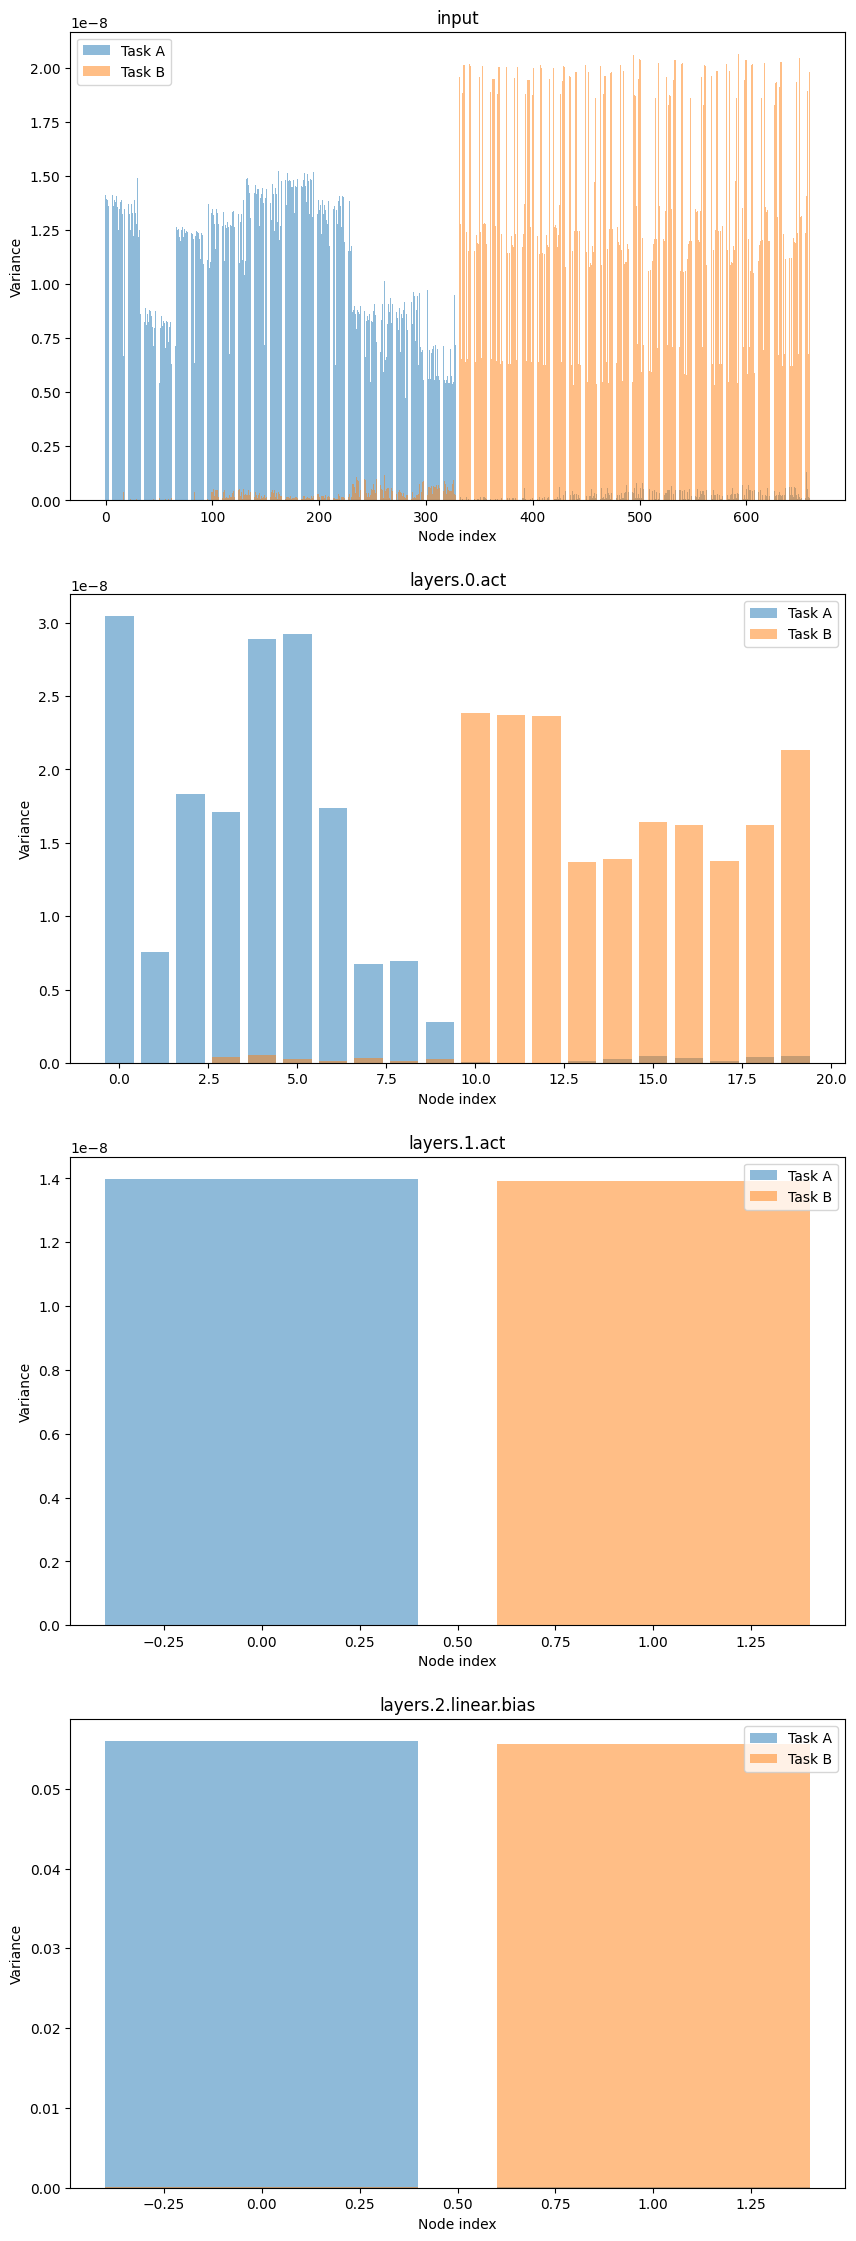

In [29]:
fig, axes = plt.subplots(len(layer_keys), figsize=(10, 7 * len(layer_keys)))

for lk, ax in zip(layer_keys, axes):
    ax.bar(range(len(vars[lk]["A"])), vars[lk]["A"], alpha=0.5, label="Task A")
    ax.bar(range(len(vars[lk]["B"])), vars[lk]["B"], alpha=0.5, label="Task B")

    ax.set_xlabel("Node index")
    ax.set_ylabel("Variance")
    _ = ax.legend()
    _ = ax.set_title(lk)

Ok cool so whilst this is showing me _some_ interference between tasks at early layers, it's not so strong really. Now to colour the nodes in a graph plot according to task variance because it might look pretty.

The fact that the activation varies across different nodes suggests that perhaps the gradients aren't redundant (even though they looked similar in the previous plots).

In [30]:
max_width = 1.0

pos = nx.get_node_attributes(G, "pos")
edge_weights = nx.get_edge_attributes(G, "weight")
scaled_weights = {
    (u, v): weight / max(edge_weights.values()) * max_width
    for (u, v), weight in edge_weights.items()
}

/Users/JBremner/miniconda3/envs/physics-mi/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


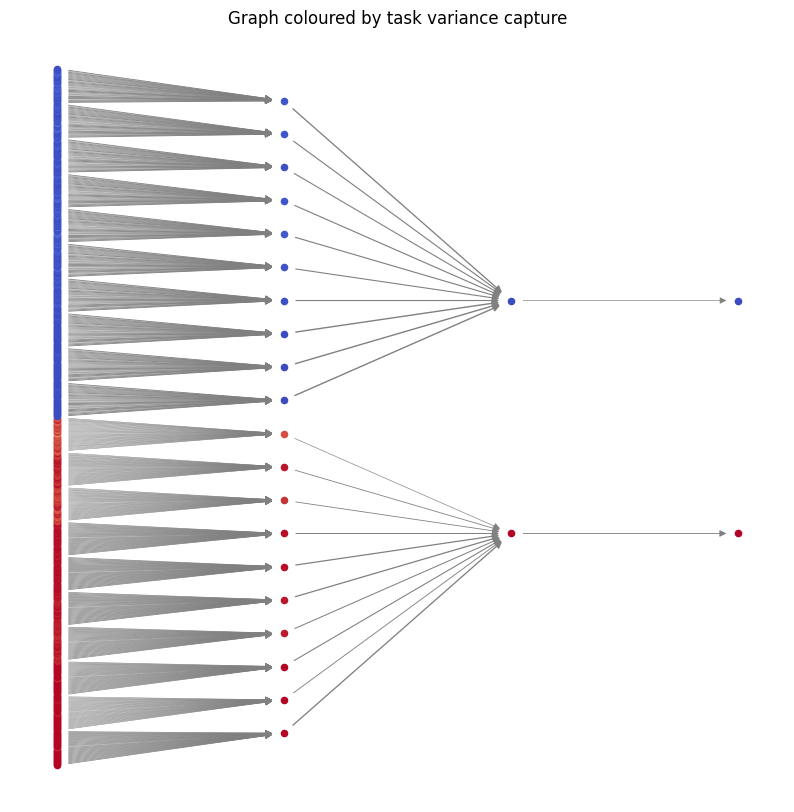

In [31]:
from matplotlib.cm import coolwarm, PiYG

fig, ax = plt.subplots(figsize=(10, 10))


def get_node_color(varA, varB):
    """Maps the variance of task A and task B to a color.

    Args:
        varA (float): Variance for task A dataset
        varB (float): Variance for task B dataset

    Returns:
        color (tuple): RGB tuple for color
    """
    pA = varA / (varA + varB)

    cm = coolwarm
    return cm(pA)


# Draw nodes
for node, attr in G.nodes(data=True):
    color = get_node_color(attr["var_A"], attr["var_B"])
    nx.draw_networkx_nodes(
        G.nodes[node], pos, nodelist=[node], node_color=color, node_size=20, ax=ax
    )

# Draw edges with weights influencing the line thickness
for (u, v), weight in scaled_weights.items():
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=weight, edge_color="gray", ax=ax
    )

ax.set_title("Graph coloured by task variance capture")
_ = ax.axis("off")  # Turn off the axis

This is showing us the same information as the previous plots but it's harder to see what's going on / it's kind of boring (because it separates so well hehe). I still haven't understood why there are the same number of unique gradients for each node 🤔 surely it's something trivial?

This hasn't really done much but confirm what I already knew in a neat way but let's think about what else we can do to understand the important Q of the cross-node weights:
- could produce mean node activations from the validation set
- examine how individual examples activate different nodes (around the mean)

## Single example analysis

In [32]:
eidx = 18

means = defaultdict(dict)
for lk in layer_keys:
    neuron_acts = valid_ios[lk]
    layer_nodes = [node for node, attr in G.nodes(data=True) if attr.get("layer") == lk]
    node_comps = torch.stack(
        [attr["comp"] for _, attr in G.subgraph(layer_nodes).nodes(data=True)]
    )
    node_acts = torch.einsum("ij,kj->ik", neuron_acts, node_comps)
    means[lk] = node_acts.mean(dim=0)
    bounds = torch.stack((node_acts.min(dim=0).values, node_acts.max(dim=0).values))
    symmetric_bound_mags = (
        (bounds - node_acts.mean(dim=0)).abs().max(dim=0).values
    )  # either side of mean
    symmetric_bounds = torch.stack(
        (
            node_acts.mean(dim=0) - symmetric_bound_mags,
            node_acts.mean(dim=0) + symmetric_bound_mags,
        )
    )
    scaled_node_acts = (node_acts - symmetric_bounds[0]) / (
        symmetric_bounds[1] - symmetric_bounds[0]
    )

    for i, node in enumerate(layer_nodes):
        G.nodes[node]["mean_valid"] = float(means[lk][i])
        G.nodes[node]["scaled_node_act"] = scaled_node_acts[eidx][i]

In [33]:
valid_ios["input"][eidx]

tensor([0.9076, 1.0701, 0.6212, 0.1559])

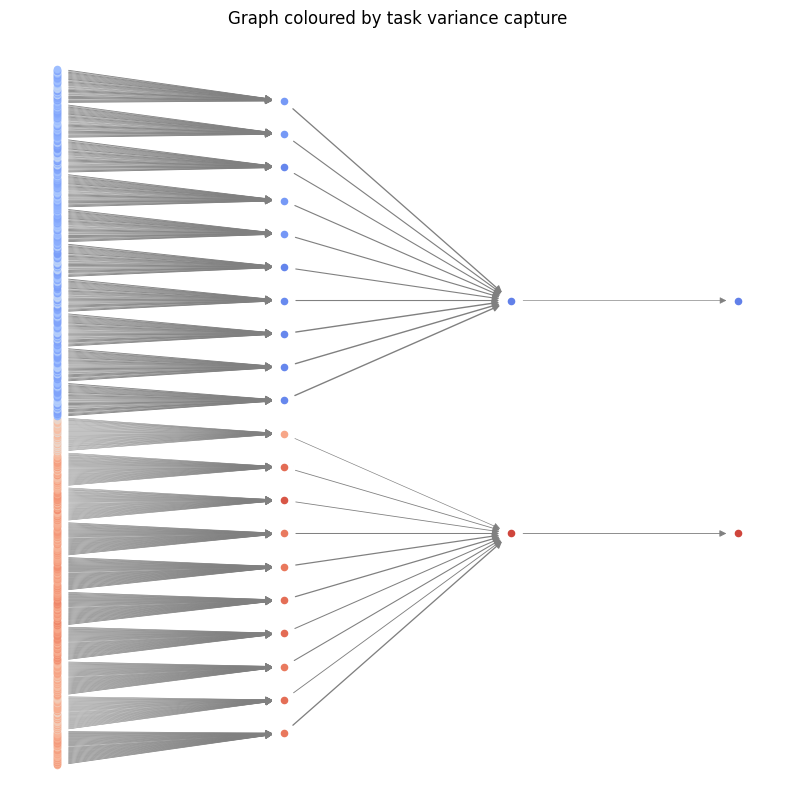

In [34]:
from matplotlib.cm import coolwarm, PiYG

fig, ax = plt.subplots(figsize=(10, 10))


def get_node_color(varA, varB):
    """Maps the variance of task A and task B to a color.

    Args:
        varA (float): Variance for task A dataset
        varB (float): Variance for task B dataset

    Returns:
        color (tuple): RGB tuple for color
    """
    pA = varA / (varA + varB)

    cm = coolwarm
    return cm(pA)


# Draw nodes
for node, attr in G.nodes(data=True):
    scaled_node_act = attr["scaled_node_act"]
    nx.draw_networkx_nodes(
        G.nodes[node],
        pos,
        nodelist=[node],
        node_color=coolwarm(scaled_node_act),
        node_size=20,
        ax=ax,
    )

# Draw edges with weights influencing the line thickness
for (u, v), weight in scaled_weights.items():
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=weight, edge_color="gray", ax=ax
    )

ax.set_title("Graph coloured by task variance capture")
_ = ax.axis("off")  # Turn off the axis

So in this model at least (a monotonically increasing mapping from $(x_1,x_2) \rightarrow x_1x_2$), larger inputs and larger outputs seem to also mean larger intermediate nodes. It isn't immediately obvious that this should be the case, but I suppose it saves the model needing to use some of its parameters to do an inversion at the end.

## Examine unique gradient component cosine similarity

I have a feeling there's lots of redundancy, overlap and multi-counting (generalisation of double counting to n times) happening in this graph as the gradients aren't orthogonal to each other. I think a simplification is in order.

It could be that the splintering of unique gradients is just what results in the output bias (i.e. inaccurate performance) and it hides the true underlying algorithm.

In [80]:
lk = "layers.0.act"
olk = "layers.1.act"
lidx = 1

layer_ios = valid_ios[lk][eidx]
uq_grads = {
    lk: {cidx: unique(value, dim=0)[0] for cidx, value in grads[lk].items()}
    for lk in layer_keys
}

In [90]:
deltas = defaultdict(dict)
for output_node in uq_grads[lk].keys():
    for input_node, grad in enumerate(uq_grads[lk][output_node]):
        linputs = layer_ios.clone()
        out = scaffold_model(lidx, linputs)
        p_inputs = linputs + grad
        p_out = scaffold_model(lidx, p_inputs)
        out_act = torch.dot(out, uq_grads[olk][output_node][0])
        p_out_act = torch.dot(p_out, uq_grads[olk][output_node][0])
        Δ = p_out_act - out_act
        deltas[output_node][input_node] = float(Δ)

In [124]:
t = torch.cat([t for _, t in uq_grads["input"].items()])
# t = uq_grads["input"][0]
t = t / t.norm(
    dim=1, keepdim=True
)  # normalise for this analysis because we just care about orthogonality

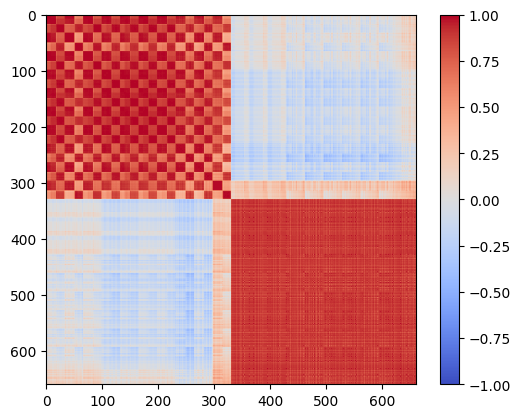

In [125]:
import matplotlib.colors as mcolors

data = torch.einsum("ij,kj->ik", t, t)

plt.imshow(data)
# Set the colormap to something diverging
cmap = plt.get_cmap("coolwarm")

# Create a centered normalization
norm = mcolors.CenteredNorm(vcenter=0, halfrange=abs(data).max())

# Plot the data with the divergent colormap and centered normalization
plt.imshow(data, cmap=cmap, norm=norm)
plt.colorbar()  # Add color bar legend

Thoughts:
- We have a lot of very similar gradients (as expected). Got to be careful though because this might not apply to more complicated tasks.
- Might remedy this my some kind of clustering after all.
- if we have a large number of unique components but they mainly differ in their _magnitude_ not their direction (as it seems is the case here), then we could interpret that as smaller inputs having a smaller gradient than larger inputs (due to the specific mechanics of this product task) i.e. $(0.1+\Delta)(0.1+\Delta) - (0.1)(0.1) \lt (0.9+\Delta)(0.9+\Delta) - (0.9)(0.9)$. Let's examine this.

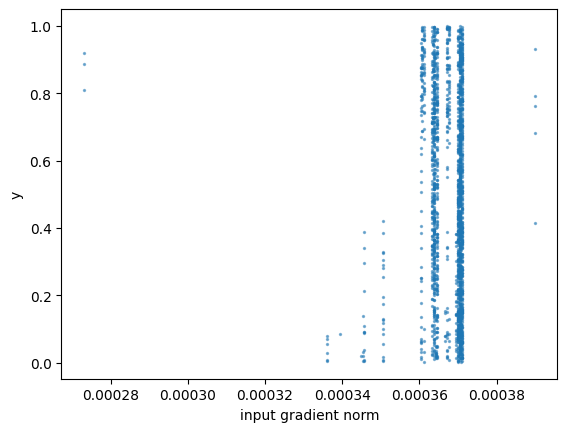

In [169]:
y = torch.mul(*valid_ios["input"][:, :2].T)
x = (
    torch.stack(list(grads["input"].values())[: len(grads["input"].keys()) // 2])
    .norm(dim=-1)
    .mean(0)
)

fig, ax = plt.subplots()

ax.scatter(x, y, s=2, alpha=0.5)
ax.set_xlabel("input gradient norm")
_ = ax.set_ylabel("y")

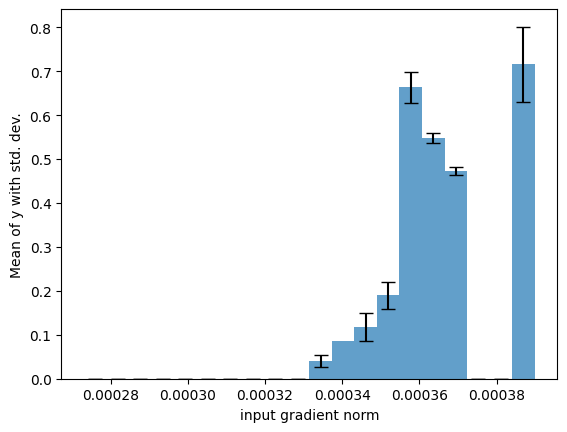

In [170]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming x and y are defined as per your code

# Step 1: Define bins for x
num_bins = 20  # You can adjust the number of bins
bins = torch.linspace(x.min(), x.max(), steps=num_bins + 1)
indices = torch.bucketize(x, bins)  # Assign each x to a bin

# Step 2: Calculate mean and std of y for each bin
bin_means = torch.zeros(num_bins)
bin_stds = torch.zeros(num_bins)
bin_errs = torch.zeros(num_bins)

for i in range(1, num_bins + 1):
    bin_mask = indices == i
    bin_values = y[bin_mask]

    if len(bin_values) > 0:
        bin_means[i - 1] = bin_values.mean()
        bin_stds[i - 1] = bin_values.std()
        bin_errs[i - 1] = bin_stds[i - 1] / len(bin_values) ** 0.5

# Step 3: Plot the bar plot with error bars
bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the center of each bin

fig, ax = plt.subplots()
ax.bar(
    bin_centers,
    bin_means,
    width=np.diff(bins),
    yerr=bin_errs,
    align="center",
    alpha=0.7,
    capsize=5,
)
ax.set_xlabel("input gradient norm")
ax.set_ylabel("Mean of y with std. dev.")

plt.show()

Hmm it seems roughly true that higher gradients have higher output values. I'd imagine this might be more true if we were propagating from the output. Here's we're relying on the fact that intermediate activations seem to correlate.

Let's try a PACMAP reduction again but on the normalised components to see if clustering is an option again.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


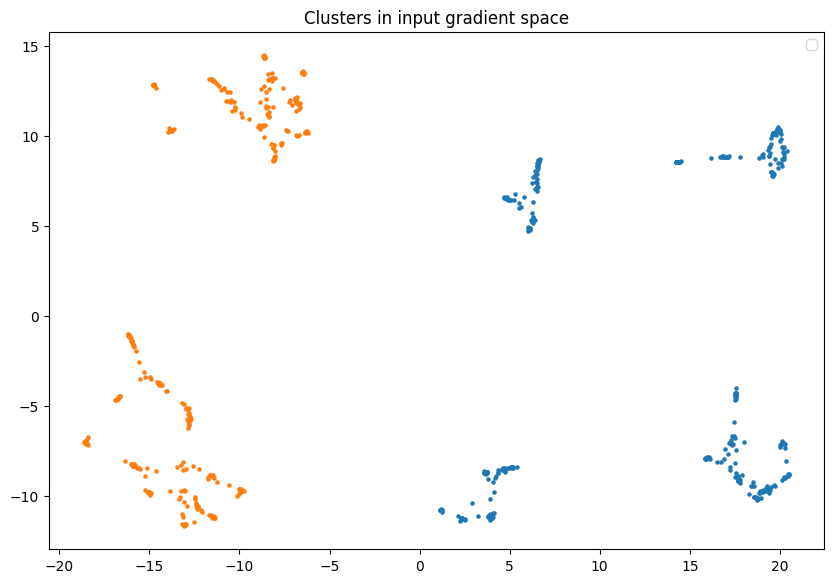

In [187]:
import pacmap

fig, ax = plt.subplots(figsize=(10, 10))

embedding = pacmap.PaCMAP(
    n_components=2,
    n_neighbors=None,
    MN_ratio=0.5,
    FP_ratio=2.0,
    save_tree=True,
    distance="angular",
)

# fit the data (The index of transformed data corresponds to the index of the original data)
reduced_data = embedding.fit_transform(t.numpy(), init="pca")


xy = reduced_data
xy = [
    xy[: len(xy) // 2],
    xy[len(xy) // 2 :],
]  # grouping into different task components

for sample in xy:
    ax.scatter(
        sample[:, 0],
        sample[:, 1],
        s=5,
        alpha=1.0,
        marker="o",
    )


ax.set_title("Clusters in input gradient space")
ax.set_aspect("equal")
_ = ax.legend(loc="upper right")

Right so this structure makes life more difficult as we need to then define the scale over which we're interested in breaking down the components. This will range from unique $\rightarrow$ single component. It might be that we can use hierarchical clustering and set an angular length scale that we're interested in e.g. a cosine similarity of $\gt 0.95$.

In the example above, it looks like we might choose 6 clusters/nodes overall as a sensible number.

The thing is, the gradients (their directions and magnitudes) will vary slightly with the differing magnitude of the inputs (at least at the input layer and probably at the following layers too), so it doesn't exactly make sense to talk about a single computational graph that applies to every example. 

It's starting to feel like however I cut it, this idea of representing the network as some computational graph doesn't quite make sense. It's an oversimplification of what is actually an inherently non-linear process. Perhaps I shouldn't worry so much about the connectivity between layers and instead consider intra-layer connectivity and activation. There is structure in these and if we're interested in picking out individual tasks then it would be a start to find structure in similarity matrices like the one above.

With this idea, by comparing similarity matrices or gradient clustering with component activation, we can start to pull out which data examples activate which subtasks.

Idea:
- design a multi-input task which sometimes requires task independence and sometimes not
- ideas for this task (which I'd like to be as simple as possible):
    - a gate input which turns on or off the answer to the multiplication? i.e. if gate is open then return the multiplication as normal, otherwise set it to 0.
- I feel like this should be a pretty simple interaction which still preserves the (slight) richness of the multiplication task whilst creating some dependence on a very simple alternative task (telling whether an input is 1 or 0).
- This would hopefully allow me to start observing task mixing in a very simple way and hopefully give me some ideas as to what the method laid out here might be lacking (or not) 🤞

First I think it's probably necessary to tidy up this code though...